In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

import pandas as pd
import numpy as np

import librosa
import copy


from tqdm import tqdm

In [2]:
def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 30, len(data)), data)
    plt.show()

In [3]:
DATA_PATH = 'GTZAN'
df = pd.read_csv('%s/features_30_sec.csv' % DATA_PATH)
df['filePath'] = DATA_PATH + '/genres_original/' + df['label'] + '/' + df['filename']

ids = copy.deepcopy(df['filename'])
bits = []
index = 0

for id in ids:
    bits = id.split('.')
    ids[index] = 'id-'+bits[0][0:2]+bits[1]+'-original'
    index += 1
df['ID'] = ids

# df = df.loc[:, ['ID','filePath', 'label']]
df = df.sample(5).to_csv('test.csv', index=False)
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var         ...           \
0              2002.449060            85882.761315         ...            
1              2039.036516           213843.755497         ...            
2              1747.702312            76254.192257         ...            
3              1596.412872           166441.494769         ...            
4              1748.172116            88445.209036         ...            

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.524071    -0.408979   41.597103    -2.303523   55.062923     1.221291   
1   60.314529     0.295073   48.120598    -0.283518   51.106190     0.531217   
2   47.639427    -1.816407   52.382141    -3.439720   46.639660    -2.231258   
3   50.206673     0.636965   37.319130    -0.619121   37.259739    -3.407448   
4   75.269707    -0.916874   53.613918    -4.404827   62.910812   -11.703234   

   mfcc20_var  label                                     filePath  \
0   46.936035  blues  GTZAN/genres_original/blues/blues.00000.wav   
1   45.786282  blues  GTZAN/genres_original/blues/blues.00001.wav   
2   30.573025  blues  GTZAN/genres_original/blues/blues.00002.wav   
3   31.949339  blues  GTZAN/genres_original/blues/blues.00003.wav   
4   55.195160  blues  GTZAN/genres_original/blues/blues.00004.wav   

                    ID  
0  id-bl00000-original  
1  id-bl00001-original  
2  id-bl00002-original  
3  id-bl00003-original  
4  id-bl00004-original  

[5 rows x 62 columns]

In [23]:
import IPython.display as ipd
ipd.Audio(df['filePath'][0])

In [6]:
def create_spectrogram(wave_data, sample_rate, sample_rate_new = 16000):
    # downsample to fs = 16kHz 
    wave_data = librosa.core.resample(wave_data, 
                          sample_rate, 
                          sample_rate_new)

    sample_rate = sample_rate_new

    # normalize input amplitude
    wave_data = librosa.util.normalize(wave_data)  

    # bring audio to uniform lenth of appr. 30s
    wave_data = wave_data[:465984]


    # time-frequency transformation with Mel-scaling
    spectrogram = librosa.feature.melspectrogram(wave_data,
                                                 sr=sample_rate,
                                                 n_mels     = 80,
                                                 power      = 2.0,
                                                 norm       = 1)


    # transform to Decibel scale
    spectrogram = librosa.power_to_db(spectrogram)

    # re-shape to final segment size
    return spectrogram.astype(np.float32)

In [7]:
temp_wd, temp_sr = librosa.core.load(df['filePath'][0], sr = None, mono = True, dtype = np.float32)
temp_wd = librosa.core.resample(temp_wd, temp_sr, 16000)
print(len(temp_wd[:465984]) / 16000)
print(len(temp_wd))
print(temp_sr)

29.124
480214
22050


In [8]:
# noise injection
def noise_injected_data(data, noise_factor):
    noise = np.random.randn(len(data)) # let data length = 5 | [0.1, 0.2, 0.3, 0.1, 0.15]
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [88]:
augmented_data_test = noise_injected_data(temp_wd, 0)
ipd.Audio(augmented_data_test, rate=16000)

In [83]:
augmented_data_test = noise_injected_data(temp_wd, 0.2)
ipd.Audio(augmented_data_test, rate=16000)

In [12]:
def time_stretched_data(data, rate=1):
    input_length = 465984
    data = librosa.effects.time_stretch(data, rate)
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")

    return data


data_stretch = noise_injected_data(time_stretched_data(temp_wd, 0.8), 0.005)
ipd.Audio(data_stretch, rate=16000)

In [9]:
# pitch shift
def pitch_shifted_data(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [18]:
data_pitch_shift = pitch_shifted_data(temp_wd, 16000, 4.5)
ipd.Audio(data_pitch_shift, rate=16000)

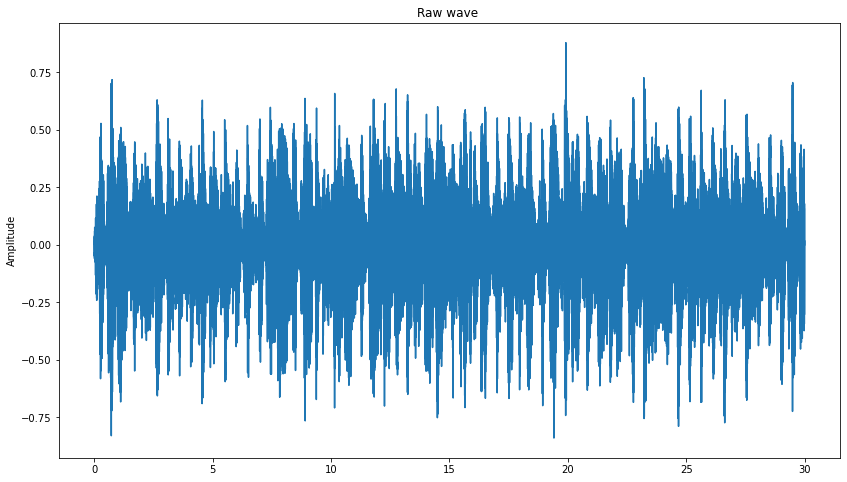

In [11]:
plot_time_series(temp_wd)

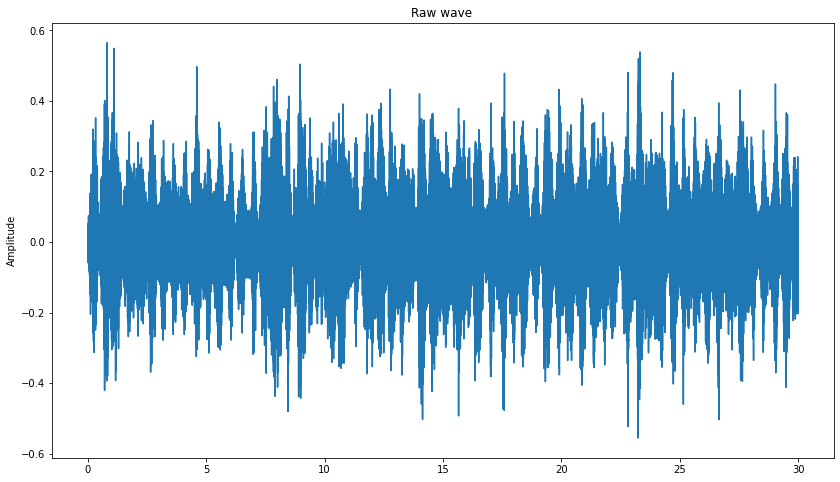

In [12]:
plot_time_series(data_pitch_shift)

In [75]:
# shifting time
def time_shifted_data(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading / tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

In [86]:
data_time_shift = time_shifted_data(temp_wd, 16000, 5, 'both')
ipd.Audio(data_time_shift, rate=16000)

In [87]:
from .gtzan import GtzanData


ModuleNotFoundError: No module named '__main__.gtzan'; '__main__' is not a package

In [89]:
df.head()


filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  \
0              2002.449060            85882.761315   
1              2039.036516           213843.755497   
2              1747.702312            76254.192257   
3              1596.412872           166441.494769   
4              1748.172116            88445.209036   

                      ...                       mfcc17_mean  mfcc17_var  \
0                     ...                         -1.690215   36.524071   
1                     ...                         -0.731125   60.314529   
2                     ...                         -7.729093   47.639427   
3                     ...                         -3.319597   50.206673   
4                     ...                         -5.454034   75.269707   

   mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  \
0    -0.408979   41.597103    -2.303523   55.062923     1.221291   46.936035   
1     0.295073   48.120598    -0.283518   51.106190     0.531217   45.786282   
2    -1.816407   52.382141    -3.439720   46.639660    -2.231258   30.573025   
3     0.636965   37.319130    -0.619121   37.259739    -3.407448   31.949339   
4    -0.916874   53.613918    -4.404827   62.910812   -11.703234   55.195160   

   label                                     filePath  
0  blues  GTZAN/genres_original/blues/blues.00000.wav  
1  blues  GTZAN/genres_original/blues/blues.00001.wav  
2  blues  GTZAN/genres_original/blues/blues.00002.wav  
3  blues  GTZAN/genres_original/blues/blues.00003.wav  
4  blues  GTZAN/genres_original/blues/blues.00004.wav  

[5 rows x 61 columns]

In [1]:
anna = 'cute'

In [2]:
anna

'cute'